In [ ]:
from openai import OpenAI
import polars as pl
import uuid
import httpx
import asyncio
from qdrant_client import QdrantClient, models
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.manifold import TSNE
import numpy as np

In [ ]:
# CONFIG
OPENAI_API_KEY = "<OPENAI_API_KEY>"
OPENAI_EMBEDDING_MODEL = "text-embedding-3-small"
QDRANT_HOST = "localhost"
QDRANT_PORT = 6333
QDRANT_COLLECTION_NAME = "adidas_products"

In [ ]:
# INIT
oai_client = OpenAI(api_key=OPENAI_API_KEY)
qdrant_client = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)

## Preparing the Environment

In [ ]:
# QDRANT COLLECTION
qdrant_client.create_collection(
    collection_name=QDRANT_COLLECTION_NAME,
    vectors_config=models.VectorParams(
        size=1536,                          # openai embedding dimension
        distance=models.Distance.COSINE,
    ),
    quantization_config=models.ScalarQuantization(
        scalar=models.ScalarQuantizationConfig(
            type=models.ScalarType.INT8,
            always_ram=True
        )
    )
)

In [25]:
# PREPROCESS DATA
df = pl.scan_csv("./data/adidas_usa.csv")
df = df.with_columns(
    pl.col("sku").alias("productSKU"),
    pl.col("name").alias("productName"),
    pl.col("color").alias("productColor"),
    pl.col("category").alias("productCategory"),
    pl.col("selling_price").alias("productPrice"),
    pl.col("description").alias("productDescription"),
    # pl.col("images").map_elements(lambda x: ast.literal_eval(x)[0].replace("1920", "240"), return_dtype=str).alias("productImage"),
    pl.col("images").map_elements(lambda x: x.split('~'), return_dtype=list[str]).alias("productImages")
)\
    .select("productSKU", "productName", "productColor", "productCategory", "productPrice", "productDescription", "productImages")\
    .collect()

In [26]:
# CONVERT TO LIST OF DICT (WILL BE OUR METADATA)
data = df.to_dicts()

In [27]:
# DOWNLOAD IMAGES LOCALLY
async def download_product(product: dict) -> str:
    async with httpx.AsyncClient() as client:
        for url in product.get("productImages"):
            try:
                response = await client.get(url, timeout=10)
                response.raise_for_status()
                path = f"./data/adidas/{product['productSKU']}.jpg"
                with open(path, "wb") as f:
                    f.write(response.content)
                    return {"productSKU": product['productSKU'], "productImage": path}
            except Exception as e:
                # print(f"Error downloading {url}: {e}")
                continue
        return {"productSKU": product['productSKU'], "productImage": None}
    
res = await asyncio.gather(*[download_product(product) for product in data])

In [10]:
df.columns[:-1]

['productSKU',
 'productName',
 'productColor',
 'productCategory',
 'productPrice',
 'productDescription']

In [28]:
# MERGE TO ORIGINAL DATAFRAME
df_img = pl.from_dicts(res)
df = df.join(df_img, on="productSKU", how="left")\
    .drop_nulls("productImage")\
    .select(df.columns[:-1] + ["productImage"])     # replace productImages (list) with productImage path

data = df.to_dicts()

In [29]:
len(data)

837

In [12]:
# FORMAT CONTENT PAYLOAD
content = ['\t'.join([f"{k}: {v}" for k, v in item.items()]) for item in data]
content[:5]

["productSKU: BC0770\tproductName: Five Ten Kestrel Lace Mountain Bike Shoes\tproductColor: Grey\tproductCategory: Shoes\tproductPrice: 150\tproductDescription: Lace up and get after it. The Five Ten Kestrel Lace Mountain Bike Shoes offer efficient pedal power with low-profile style. The wide platform is compatible with all clipless pedals and offers high-friction grip on and off the bike. You'll find the find comfort and versatility for extended trail rides and afterwork hot laps alike.\tproductImage: ./data/adidas/BC0770.jpg",
 "productSKU: GC7946\tproductName: Mexico Away Jersey\tproductColor: White\tproductCategory: Clothing\tproductPrice: 70\tproductDescription: Clean and crisp, this adidas Mexico Away Jersey for juniors displays a design that began life in an artist's studio. Soft, quick-drying fabric keeps you comfortable. Standing out on the chest, a team badge lets fans show pride in their soccer team.\tproductImage: ./data/adidas/GC7946.jpg",
 'productSKU: FV4744\tproductName

In [13]:
# CREATE BATCHES
batches = []
bs = 250
for i in range(0, len(content), bs):
    batches.append(content[i:i+bs])
len(batches)

3

In [14]:
# CREATE EMBEDDINGS
embeddings = []
for batch in batches:
    embed = oai_client.embeddings.create(
        input=batch,
        model=OPENAI_EMBEDDING_MODEL
    )
    embeddings.extend([item.embedding for item in embed.data])

len(embeddings)

681

In [ ]:
# INGEST TO QDRANT
ids = [str(uuid.uuid4()) for _ in range(len(content))]
qdrant_client.upload_collection(
    collection_name=QDRANT_COLLECTION_NAME,
    vectors=embeddings,
    ids=ids,
    payload=[{"content": c, "metadata": m} for c, m in zip(content, data)],
    batch_size=256,
    wait=True
)

## Querying Product Data

In [89]:
def visualize_product_images(queries, payloads):
    num_queries = len(queries)
    products_per_row = max(len(payload) for payload in payloads)  # Get max products in any query for grid width.
    
    fig, ax = plt.subplots(num_queries, products_per_row, figsize=(20, 5 * num_queries))
    
    for i, (query, payload) in enumerate(zip(queries, payloads)):
        for j in range(products_per_row):
            if j < len(payload):
                ax[i, j].imshow(Image.open(payload[j]["productImage"]))
                ax[i, j].set_title(f"{payload[j]['productName']}\n{payload[j]['productCategory']}")
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
        
        ax[i, 0].set_ylabel(query, fontsize=12, labelpad=10)  # Set query as row title

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def visualize_product_rows(query, payload):
    fig, ax = plt.subplots(1, len(payload), figsize=(15, 8))

    for i, product in enumerate(payload):
        ax[i].imshow(Image.open(product["productImage"]))
        ax[i].set_title(f"{product['productName']}\n{product['productCategory']}")
        ax[i].set_axis_off()

    fig.suptitle(f"Query: {query}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 1.35])
    plt.show()

In [90]:
queries = [
    "Hey, I need fab shoes!",
    "I'm on the hunt for a stylish pair of kicks!"
]

query_embeds = oai_client.embeddings.create(input=queries, model=OPENAI_EMBEDDING_MODEL).data

### Take Top-5 Result Naively

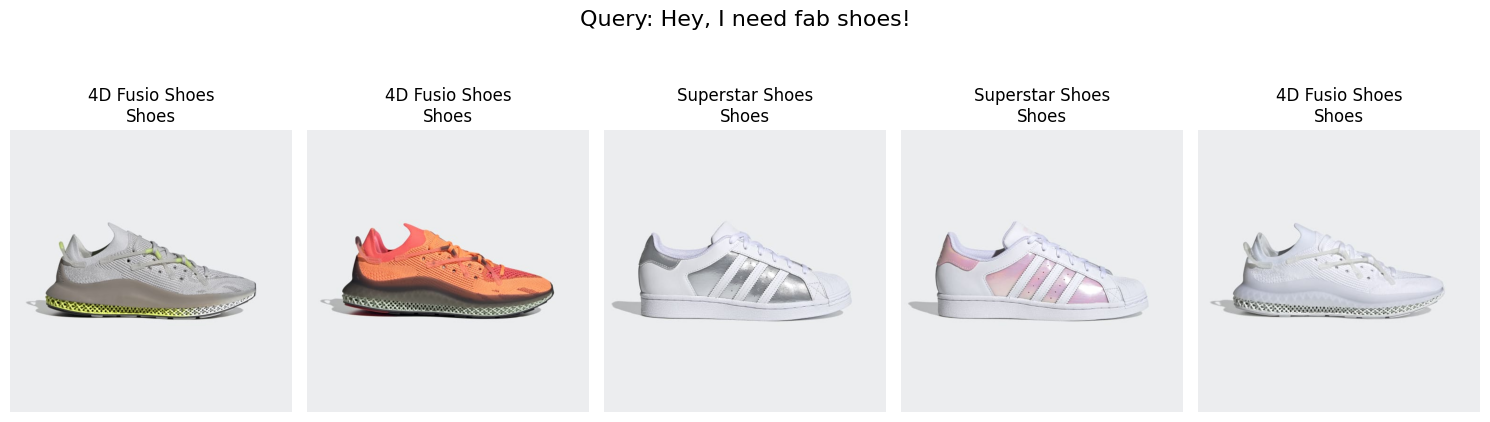

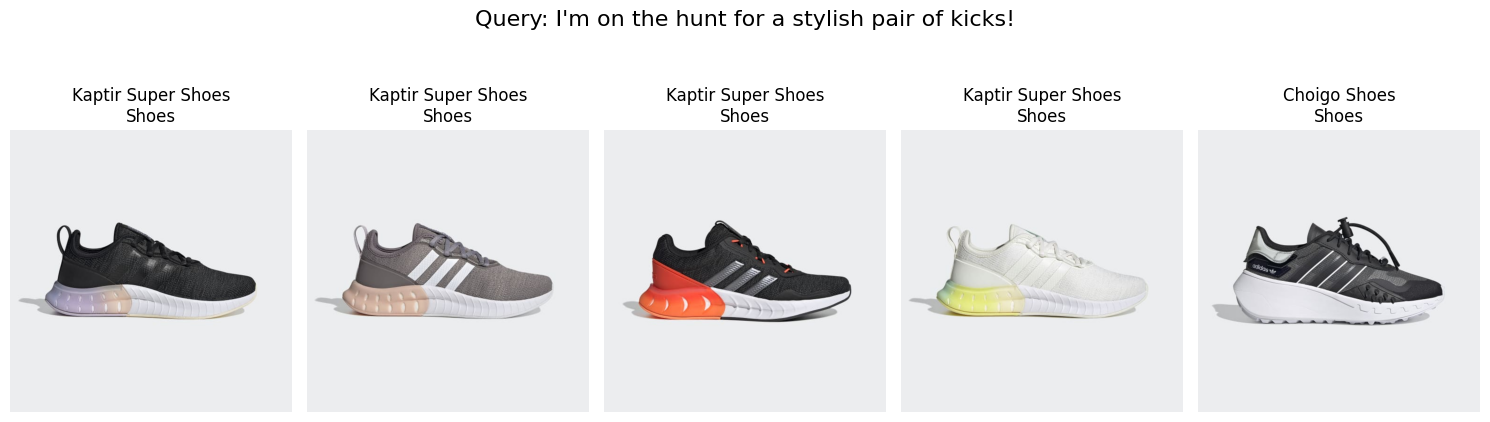

In [97]:
for q, emb in zip(queries, query_embeds):
    res = qdrant_client.query_points(
        collection_name=QDRANT_COLLECTION_NAME,
        query=emb.embedding,
        with_vectors=True,
        limit=100,
    )

    # Naively take top-5 results
    top_5 = res.points[:5]
    top_5_payload = [item.payload["metadata"] for item in top_5]

    visualize_product_rows(q, top_5_payload)

#### Embedding Visualization

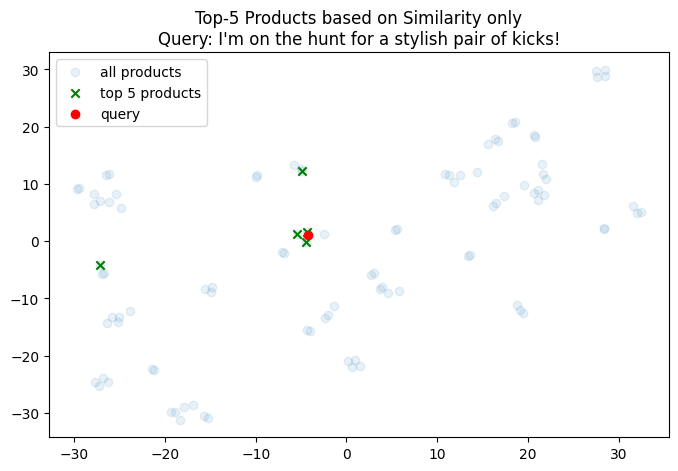

In [106]:
# using the last query result: "I'm on the hunt for a stylish pair of kicks!"
viz_indices = {item.id: i for i, item in enumerate(res.points)}

viz_emb = np.array([item.vector for item in res.points])
tsne = TSNE(n_components=2, perplexity=5).fit_transform(np.array([emb.embedding] + viz_emb))
query_tsne = tsne[0, :]
rag_tsne = tsne [1:, :]

_indices = [viz_indices[item.id] for item in top_5]

plt.figure(figsize=(8, 5))
plt.scatter(rag_tsne[:, 0], rag_tsne[:, 1], label="all products", alpha=0.1)
plt.scatter(rag_tsne[_indices, 0], rag_tsne[_indices, 1], marker='x', color='green', label="top 5 products")
plt.scatter(query_tsne[0], query_tsne[1], c='red', label="query")
plt.title(f"Top-5 Products based on Similarity only\nQuery: {q}")
plt.legend()
plt.show()

### The Secret Recipe – MMR

In [75]:
from sklearn.metrics.pairwise import cosine_similarity
from typing import List
import numpy as np

def maximal_marginal_relevance(
    query_embedding: np.ndarray,
    embedding_list: list,
    lambda_mult: float = 0.5,
    k: int = 4,
) -> List[int]:
    """Calculate maximal marginal relevance.
    
    Usage example:
    ```python
    mmr_selected = maximal_marginal_relevance(
        query_embedding=np.array(query_embed, dtype=np.float32),
        embedding_list=ret_docs["embeddings"][0],
        lambda_mult=0.4,
        k=10
    )

    print(mmr_selected)
    
    # Output
    >>> [0, 9, 6, 12, 1, 17, 7, 2, 5, 19]
    ```
    
    """
    if min(k, len(embedding_list)) <= 0:
        return []
    if isinstance(query_embedding, list):
        query_embedding = np.array(query_embedding)
    if query_embedding.ndim == 1:
        query_embedding = np.expand_dims(query_embedding, axis=0)
    similarity_to_query = cosine_similarity(query_embedding, embedding_list)[0]
    most_similar = int(np.argmax(similarity_to_query))
    idxs = [most_similar]
    selected = np.array([embedding_list[most_similar]])
    while len(idxs) < min(k, len(embedding_list)):
        best_score = -np.inf
        idx_to_add = -1
        similarity_to_selected = cosine_similarity(embedding_list, selected)
        for i, query_score in enumerate(similarity_to_query):
            if i in idxs:
                continue
            redundant_score = max(similarity_to_selected[i])
            equation_score = (
                lambda_mult * query_score - (1 - lambda_mult) * redundant_score
            )
            if equation_score > best_score:
                best_score = equation_score
                idx_to_add = i
        idxs.append(idx_to_add)
        selected = np.append(selected, [embedding_list[idx_to_add]], axis=0)
    return idxs

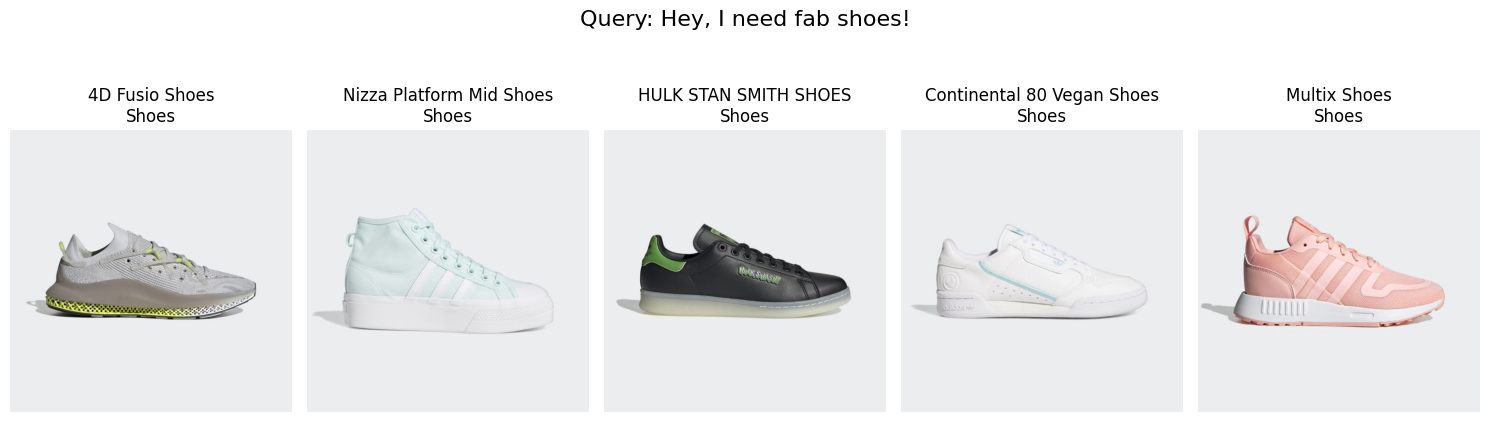

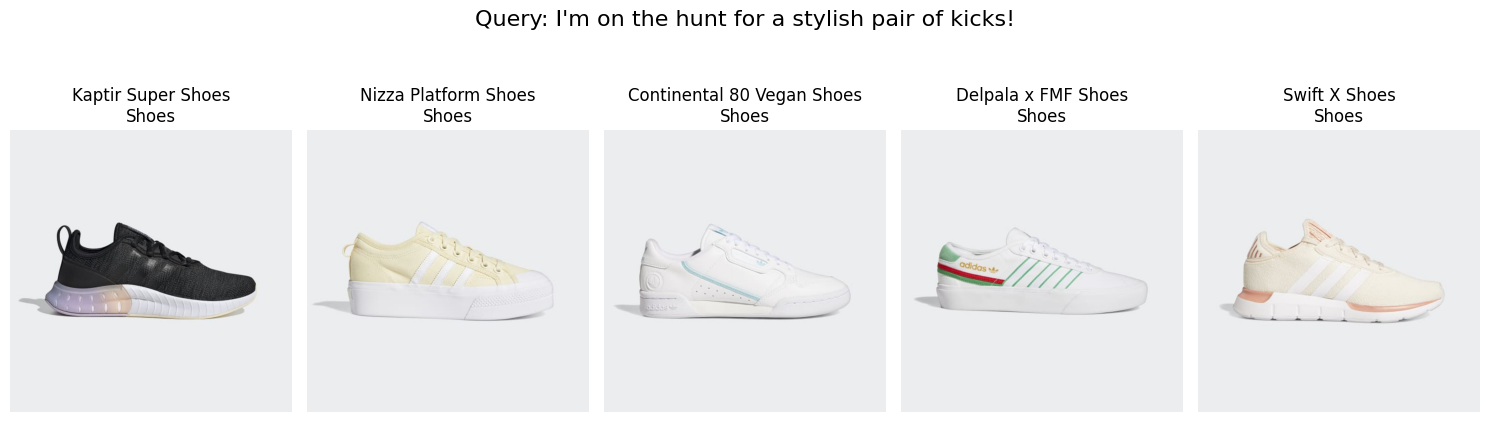

In [79]:
MMR_LAMBDA_MULT = 0.3   # prioritize diversity
MMR_K = 5   # number of results to return

for q, emb in zip(queries, query_embeds):
    res = qdrant_client.query_points(
        collection_name=QDRANT_COLLECTION_NAME,
        query=emb.embedding,
        with_vectors=True,
        limit=100,
    )

    # collect top-100 embeddings
    top_100_embeddings = [item.vector for item in res.points]

    # re-rank using MMR then take top-5 result
    top_5_mmr_indices = maximal_marginal_relevance(emb.embedding, top_100_embeddings, MMR_LAMBDA_MULT, MMR_K)
    top_5_mmr = [res.points[i] for i in top_5_mmr_indices]
    top_5_mmr_payload = [item.payload["metadata"] for item in top_5_mmr]

    visualize_product_rows(q, top_5_mmr_payload)

#### Embedding Visualization

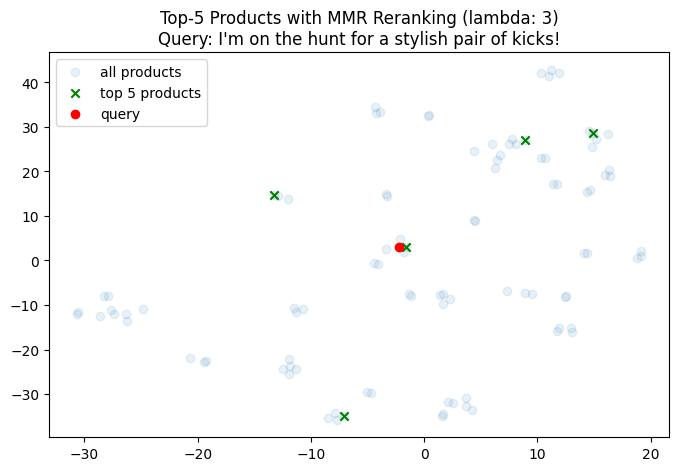

In [104]:
# using the last query result: "I'm on the hunt for a stylish pair of kicks!"
viz_indices = {item.id: i for i, item in enumerate(res.points)}

viz_emb = np.array([item.vector for item in res.points])
tsne = TSNE(n_components=2, perplexity=5).fit_transform(np.array([emb.embedding] + viz_emb))
query_tsne = tsne[0, :]
rag_tsne = tsne [1:, :]

_indices = [viz_indices[item.id] for item in top_5_mmr]

plt.figure(figsize=(8, 5))
plt.scatter(rag_tsne[:, 0], rag_tsne[:, 1], label="all products", alpha=0.1)
plt.scatter(rag_tsne[_indices, 0], rag_tsne[_indices, 1], marker='x', color='green', label="top 5 products")
plt.scatter(query_tsne[0], query_tsne[1], c='red', label="query")
plt.title(f"Top-5 Products with MMR Reranking (lambda: 3)\nQuery: {q}")
plt.legend()
plt.show()